<a href="https://colab.research.google.com/github/kshitizkool/Data-Analytics-Assignments/blob/main/Rainfall_Prediction_using_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks

np.random.seed(0)

In [3]:
data = pd.read_csv("/content/weatherAUS.csv")
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97502 entries, 0 to 97501
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           97502 non-null  object 
 1   Location       97501 non-null  object 
 2   MinTemp        96296 non-null  float64
 3   MaxTemp        96477 non-null  float64
 4   Rainfall       94999 non-null  float64
 5   Evaporation    53976 non-null  float64
 6   Sunshine       46952 non-null  float64
 7   WindGustDir    91037 non-null  object 
 8   WindGustSpeed  91046 non-null  float64
 9   WindDir9am     89400 non-null  object 
 10  WindDir3pm     94484 non-null  object 
 11  WindSpeed9am   96007 non-null  float64
 12  WindSpeed3pm   95398 non-null  float64
 13  Humidity9am    95418 non-null  float64
 14  Humidity3pm    94998 non-null  float64
 15  Pressure9am    86841 non-null  float64
 16  Pressure3pm    86888 non-null  float64
 17  Cloud9am       59421 non-null  float64
 18  Cloud3

<Axes: xlabel='RainTomorrow', ylabel='count'>

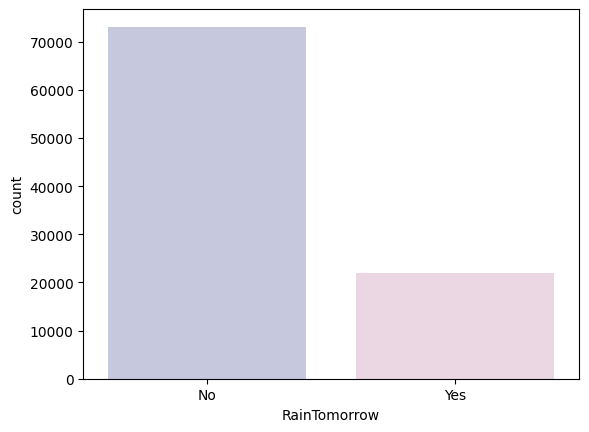

In [5]:
cols= ["#C2C4E2","#EED4E5"]
sns.countplot(x= data["RainTomorrow"], palette= cols)

<ipython-input-6-8a2cf40265ea>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = data.corr()


<Axes: >

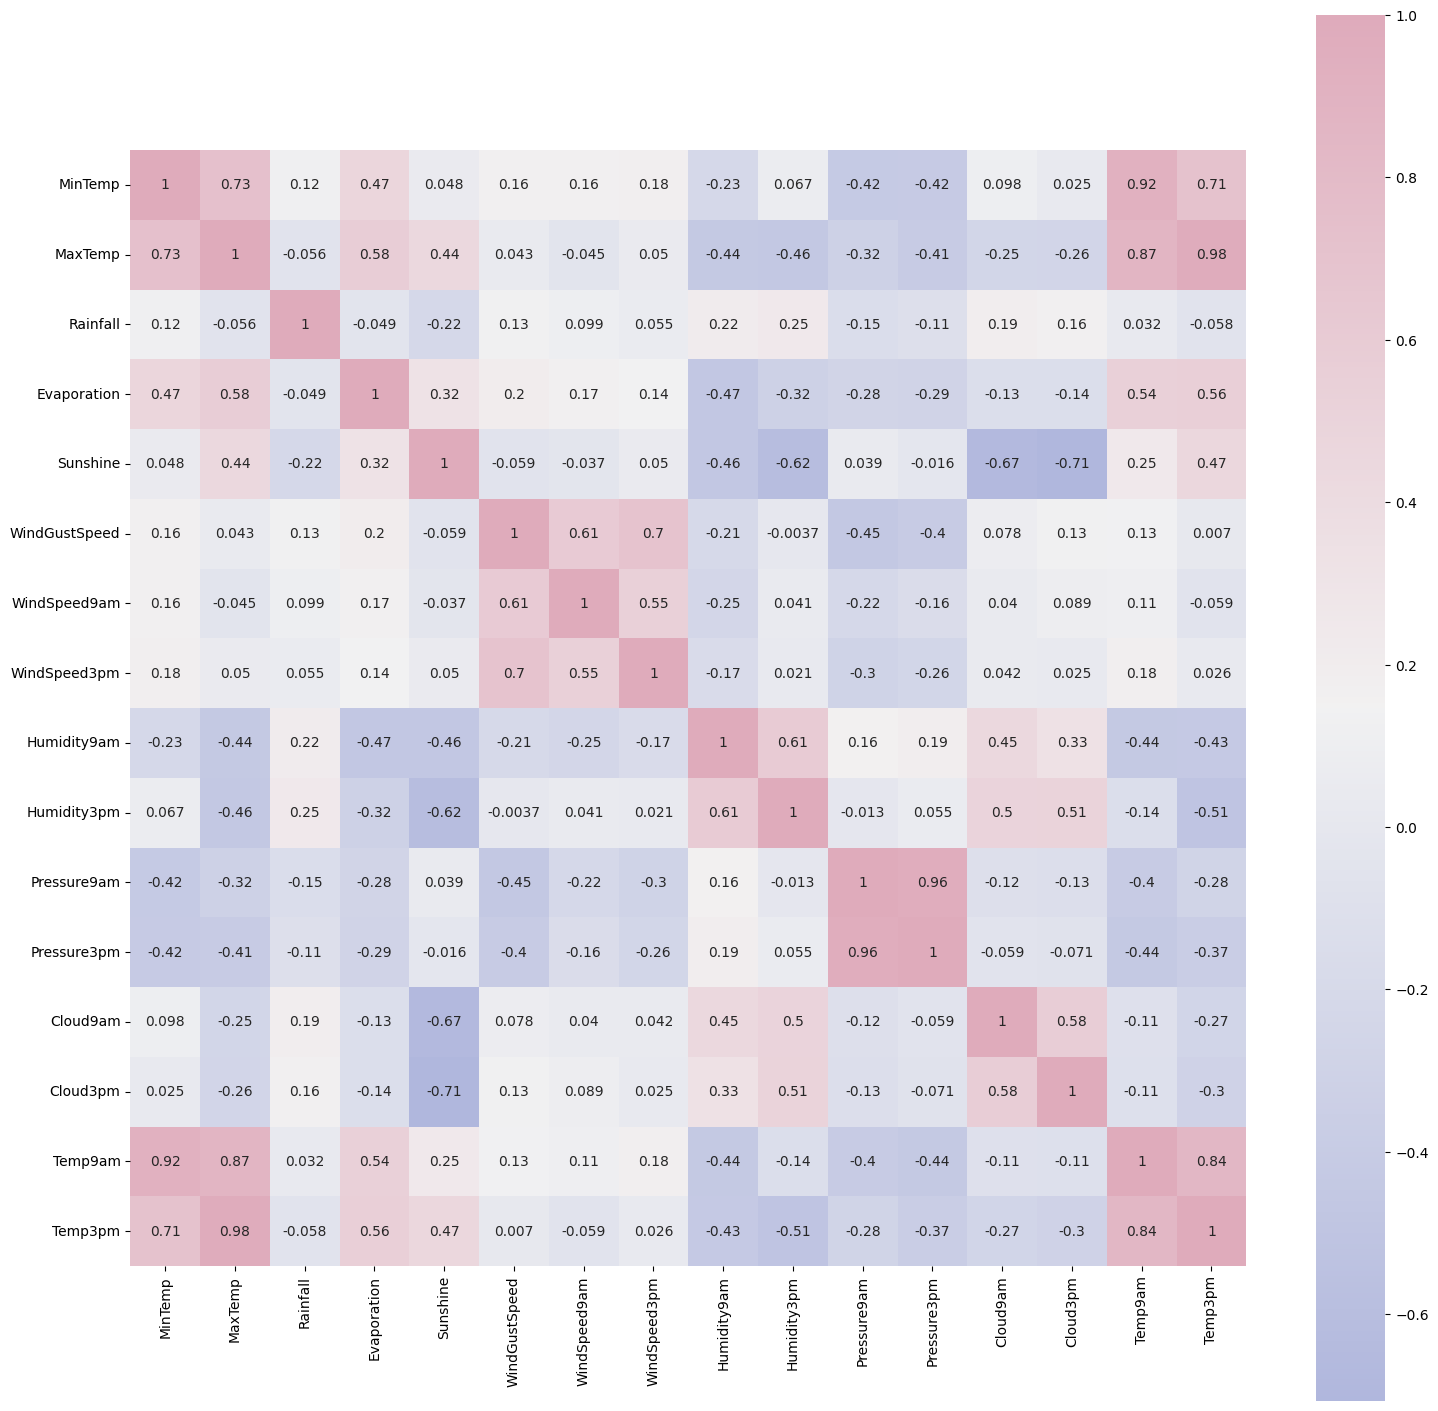

In [6]:
# Correlation amongst numeric attributes
corrmat = data.corr()
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)

In [7]:
lengths = data["Date"].str.len()
lengths.value_counts()

10    97501
9         1
Name: Date, dtype: int64

In [8]:
data['Date']= pd.to_datetime(data["Date"])
#Creating a collumn of year
data['year'] = data.Date.dt.year
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


Text(0.5, 0, 'Days In Year')

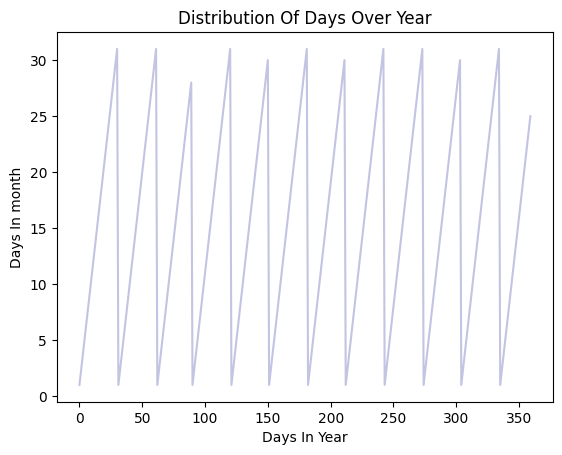

In [9]:
section = data[:360]
tm = section["day"].plot(color="#C2C4E2")
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")

Text(0.5, 0, 'Sine Encoded Months')

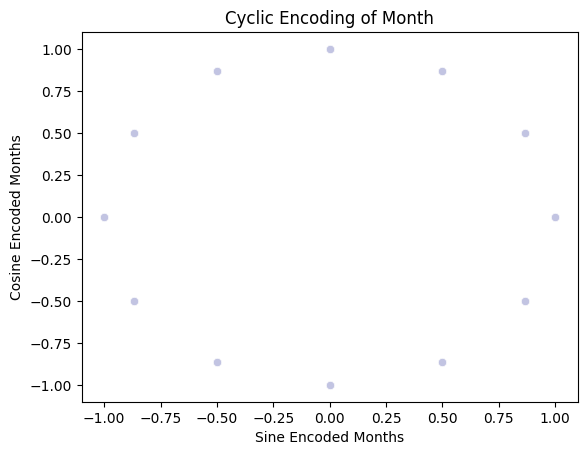

In [10]:
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=data, color="#C2C4E2")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

Text(0.5, 0, 'Sine Encoded Day')

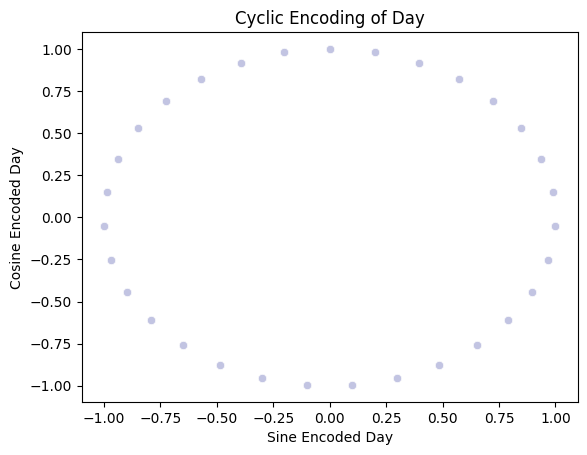

In [11]:
cyclic_day = sns.scatterplot(x='day_sin',y='day_cos',data=data, color="#C2C4E2")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

In [12]:
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [13]:

for i in object_cols:
    print(i, data[i].isnull().sum())

Location 1
WindGustDir 6465
WindDir9am 8102
WindDir3pm 3018
RainToday 2503
RainTomorrow 2501


In [14]:

for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

In [15]:
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [16]:

for i in num_cols:
    print(i, data[i].isnull().sum())

MinTemp 1206
MaxTemp 1025
Rainfall 2503
Evaporation 43526
Sunshine 50550
WindGustSpeed 6456
WindSpeed9am 1495
WindSpeed3pm 2104
Humidity9am 2084
Humidity3pm 2504
Pressure9am 10661
Pressure3pm 10614
Cloud9am 38081
Cloud3pm 39231
Temp9am 1568
Temp3pm 2045
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [17]:
for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97502 entries, 0 to 97501
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           97502 non-null  datetime64[ns]
 1   Location       97502 non-null  object        
 2   MinTemp        97502 non-null  float64       
 3   MaxTemp        97502 non-null  float64       
 4   Rainfall       97502 non-null  float64       
 5   Evaporation    97502 non-null  float64       
 6   Sunshine       97502 non-null  float64       
 7   WindGustDir    97502 non-null  object        
 8   WindGustSpeed  97502 non-null  float64       
 9   WindDir9am     97502 non-null  object        
 10  WindDir3pm     97502 non-null  object        
 11  WindSpeed9am   97502 non-null  float64       
 12  WindSpeed3pm   97502 non-null  float64       
 13  Humidity9am    97502 non-null  float64       
 14  Humidity3pm    97502 non-null  float64       
 15  Pressure9am    9750

In [19]:
label_encoder = LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97502 entries, 0 to 97501
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           97502 non-null  datetime64[ns]
 1   Location       97502 non-null  int64         
 2   MinTemp        97502 non-null  float64       
 3   MaxTemp        97502 non-null  float64       
 4   Rainfall       97502 non-null  float64       
 5   Evaporation    97502 non-null  float64       
 6   Sunshine       97502 non-null  float64       
 7   WindGustDir    97502 non-null  int64         
 8   WindGustSpeed  97502 non-null  float64       
 9   WindDir9am     97502 non-null  int64         
 10  WindDir3pm     97502 non-null  int64         
 11  WindSpeed9am   97502 non-null  float64       
 12  WindSpeed3pm   97502 non-null  float64       
 13  Humidity9am    97502 non-null  float64       
 14  Humidity3pm    97502 non-null  float64       
 15  Pressure9am    9750

In [20]:

features = data.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping target and extra columns

target = data['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names)

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,97502.0,-1.259275e-16,1.000005,-1.723311,-0.873877,-0.024444,0.931169,1.674424
MinTemp,97502.0,4.663980e-17,1.000005,-3.214225,-0.717758,-0.000024,0.764520,3.401413
MaxTemp,97502.0,1.585753e-16,1.000005,-4.033395,-0.710837,-0.022907,0.694297,3.592387
Rainfall,97502.0,1.865592e-17,1.000005,-0.273848,-0.273848,-0.273848,-0.185499,40.697830
Evaporation,97502.0,2.285350e-16,1.000005,-1.693796,-0.324184,-0.118743,0.018219,47.954624
Sunshine,97502.0,1.140343e-15,1.000005,-2.881375,0.139679,0.139679,0.139679,2.526685
WindGustDir,97502.0,1.026076e-16,1.000005,-1.714412,-0.862979,0.201312,1.052744,1.478460
WindGustSpeed,97502.0,2.046321e-16,1.000005,-2.402678,-0.628162,-0.184533,0.480910,7.061407
WindDir9am,97502.0,-1.982191e-17,1.000005,-1.648011,-0.981808,-0.093538,0.794733,1.683003
WindDir3pm,97502.0,1.865592e-17,1.000005,-1.661367,-0.780217,0.100932,0.761795,1.642944


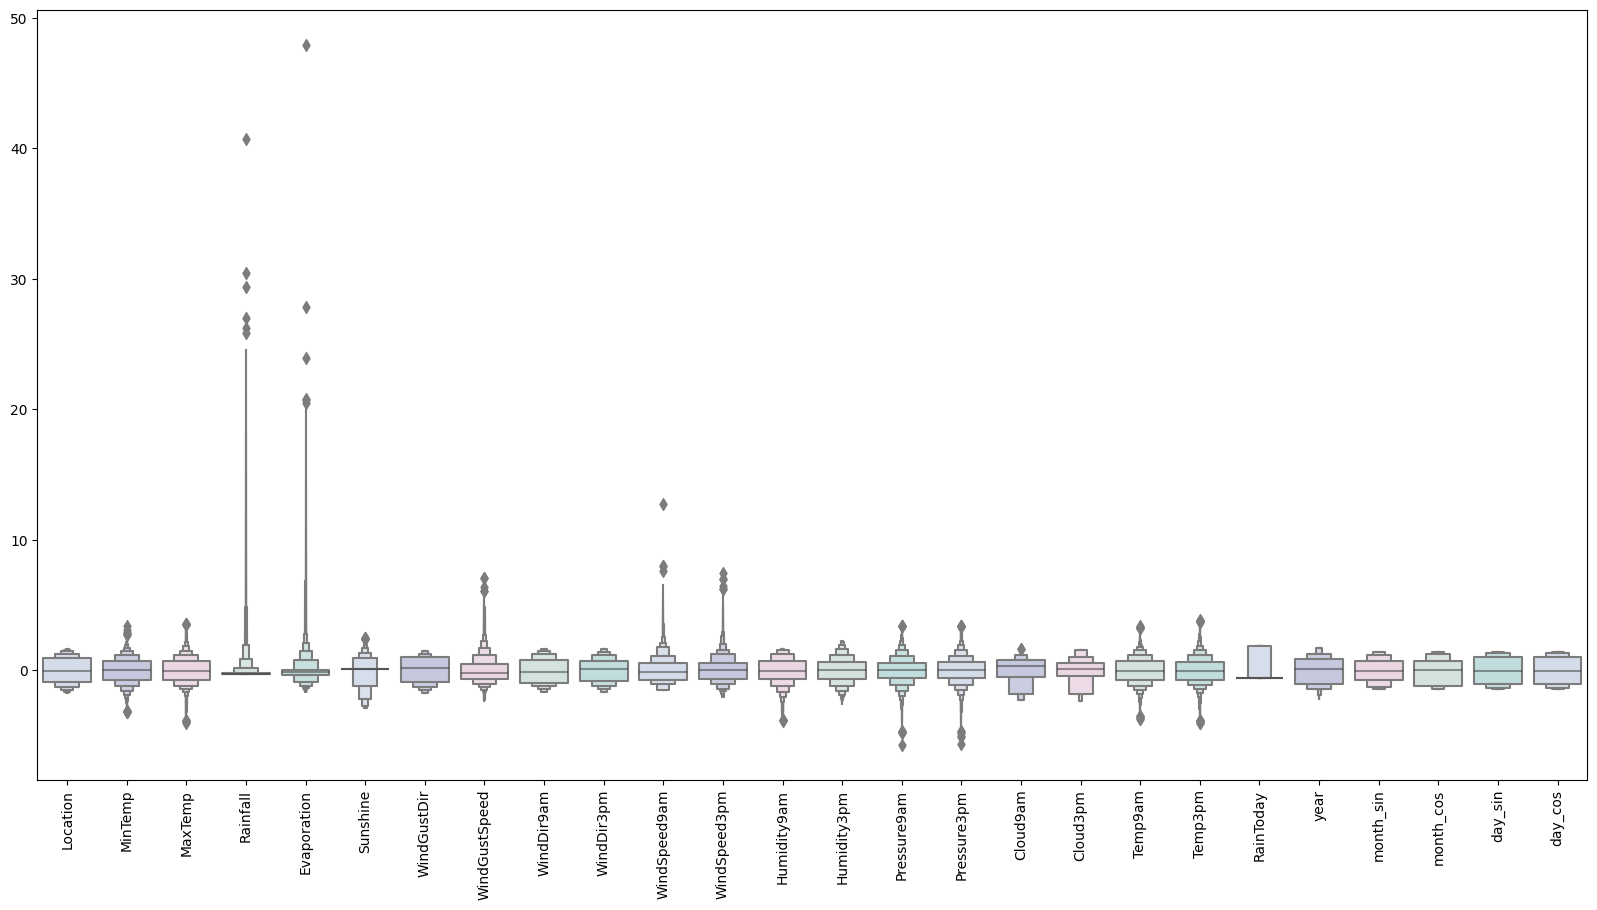

In [21]:
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [22]:
features["RainTomorrow"] = target

#Dropping with outlier

features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]

features.shape

(84802, 27)

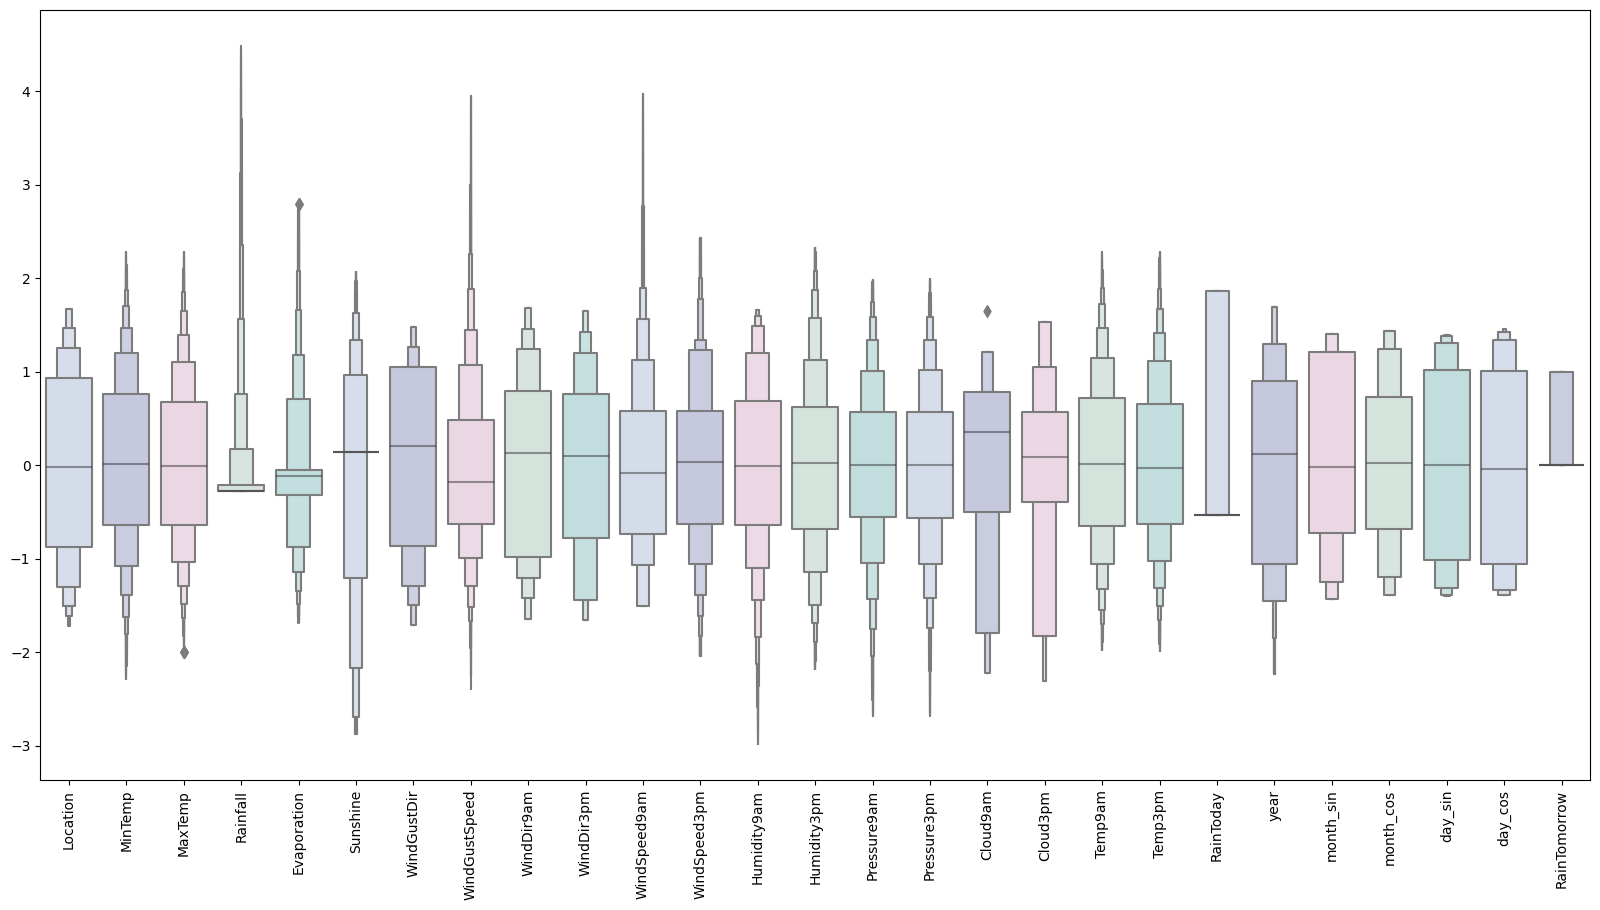

In [23]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [24]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

(84802, 26)

In [25]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
1696/1696 [==============================] - 20s 11ms/step - loss: 0.5344 - accuracy: 0.7817 - val_loss: 0.4082 - val_accuracy: 0.7833
Epoch 2/150
1696/1696 [==============================] - 7s 4ms/step - loss: 0.4454 - accuracy: 0.7819 - val_loss: 0.4007 - val_accuracy: 0.7833
Epoch 3/150
1696/1696 [==============================] - 5s 3ms/step - loss: 0.4370 - accuracy: 0.7819 - val_loss: 0.3979 - val_accuracy: 0.7833
Epoch 4/150
1696/1696 [==============================] - 7s 4ms/step - loss: 0.4361 - accuracy: 0.7819 - val_loss: 0.3958 - val_accuracy: 0.7833
Epoch 5/150
1696/1696 [==============================] - 6s 4ms/step - loss: 0.4279 - accuracy: 0.7819 - val_loss: 0.3944 - val_accuracy: 0.7833
Epoch 6/150
1696/1696 [==============================] - 7s 4ms/step - loss: 0.4248 - accuracy: 0.7819 - val_loss: 0.3932 - val_accuracy: 0.7833
Epoch 7/150
1696/1696 [==============================] - 11s 7ms/step - loss: 0.4231 - accuracy: 0.7819 - val_loss: 0.3921 - val

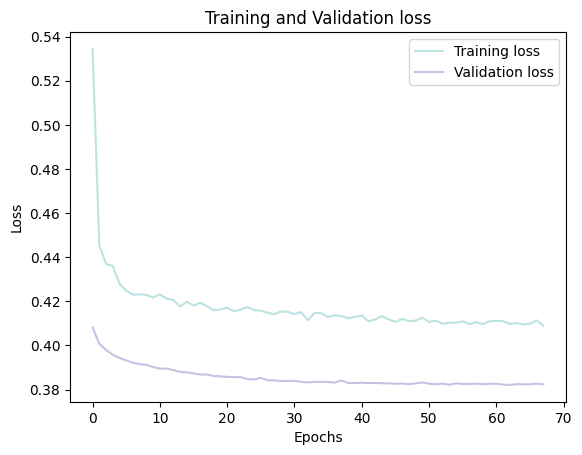

In [26]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

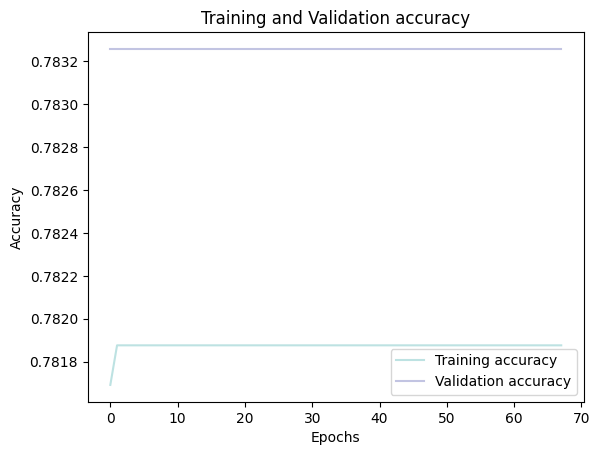

In [27]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

531/531 [==============================] - 1s 1ms/step


<Axes: >

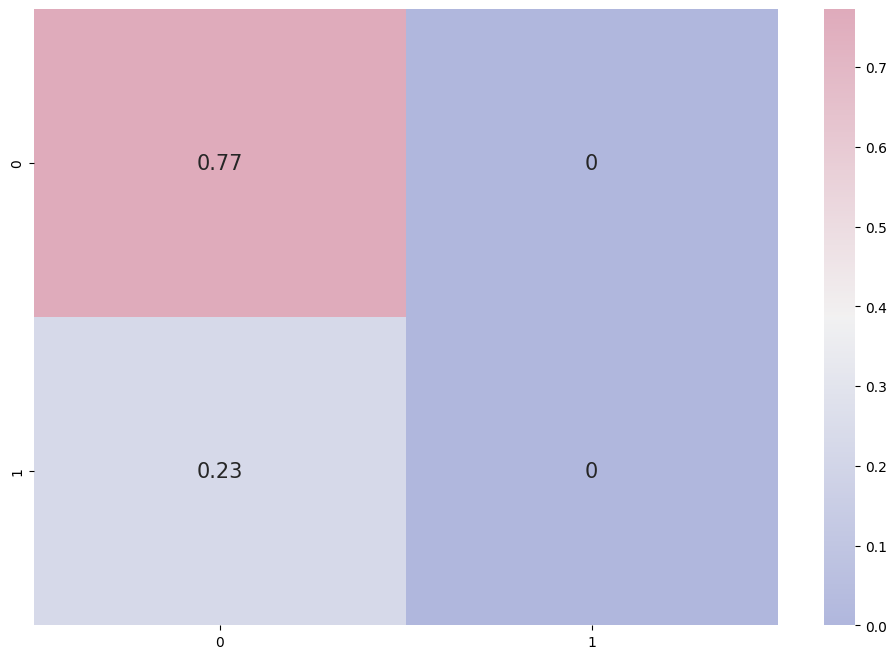

In [29]:
#Confusion Matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     13102
           1       0.00      0.00      0.00      3859

    accuracy                           0.77     16961
   macro avg       0.39      0.50      0.44     16961
weighted avg       0.60      0.77      0.67     16961



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
